In [1]:
import numpy as np
import torch
from microgrid_fun import hybrid_fhocp, gurobi_qp, Network, qp_feasible, count_parameters, state_norm, build_delta, build_stacked_input
import matplotlib.pylab as plt

data = np.load('data_costs_loads_2021_2022.npy', allow_pickle=True)
data_2021 = data[0]; data_2022 = data[1]
cbuy, csell, cprod, power_load, power_res = data_2022
cbuy_2021, csell_2021, cprod_2021, power_load_2021, power_res_2021 = data_2021

In [2]:
action_dict = {'0': np.array([[0,0,0,0,0]]),
               '1': np.array([[0,0,0,0,1]]),
               '2': np.array([[0,0,0,1,0]]),
               '3': np.array([[0,0,0,1,1]]),
               '4': np.array([[0,0,1,0,0]]),
               '5': np.array([[0,0,1,0,1]]),
               '6': np.array([[0,0,1,1,0]]),
               '7': np.array([[0,0,1,1,1]]),
               '8': np.array([[0,1,0,0,0]]),
               '9': np.array([[0,1,0,0,1]]),
               '10': np.array([[0,1,0,1,0]]),
               '11': np.array([[0,1,0,1,1]]),
               '12': np.array([[0,1,1,0,0]]),
               '13': np.array([[0,1,1,0,1]]),
               '14': np.array([[0,1,1,1,0]]),
               '15': np.array([[0,1,1,1,1]]),
               '16': np.array([[1,0,0,0,0]]),
               '17': np.array([[1,0,0,0,1]]),
               '18': np.array([[1,0,0,1,0]]),
               '19': np.array([[1,0,0,1,1]]),
               '20': np.array([[1,0,1,0,0]]),
               '21': np.array([[1,0,1,0,1]]),
               '22': np.array([[1,0,1,1,0]]),
               '23': np.array([[1,0,1,1,1]]),
               '24': np.array([[1,1,0,0,0]]),
               '25': np.array([[1,1,0,0,1]]),
               '26': np.array([[1,1,0,1,0]]),
               '27': np.array([[1,1,0,1,1]]),
               '28': np.array([[1,1,1,0,0]]),
               '29': np.array([[1,1,1,0,1]]),
               '30': np.array([[1,1,1,1,0]]),
               '31': np.array([[1,1,1,1,1]])}

In [3]:
def build_delta_vector(list_action, N):
    
    '''
    builds delta vector (N,5) from LSTM Network output
    '''
    
    # from list of actions builds a np.array with the stacked deltas for each time step of the prediction horizon
        
    delta = action_dict[str(list_action[0])]
    for i in range(1,N):
        delta = np.concatenate((delta, action_dict[str(list_action[i])]))
        
    return delta

In [4]:
N=24
N_datapoints = 16000

In [5]:
# stack battery state and forecasts
# option 1: repeat initial battery charge across time (N_points, N, 6)
# option 2: all data comes at the start, then pad with zeros (N_points, N, N*5+1)

stacked_states1 = np.zeros((N_datapoints,N,6))
stacked_states2 = np.zeros((N_datapoints,N,1+5*N))
stacked_deltas =  np.zeros((N_datapoints,N,5))
stacked_actions = np.zeros((N_datapoints,N,1))
stacked_labels =  np.zeros((N_datapoints,N,2**5))
stacked_indices = np.zeros((N_datapoints,)) # time of the day
for j in range(N_datapoints):
    x0 = np.random.rand(1,1)*225+25 #minimum battery level is 25    
    i = np.random.randint(cbuy.shape[0]-N, dtype=np.int32)
    
    x0_tmp = np.repeat(x0, N)
    cbuy_tmp = cbuy[i:i+N]
    csell_tmp = csell[i:i+N]
    cprod_tmp = cprod[i:i+N]
    power_res_tmp = power_res[i:i+N]
    power_load_tmp = power_load[i:i+N]
    
    stacked_states1[j,:] = np.dstack((x0_tmp, cbuy_tmp, csell_tmp, cprod_tmp, power_res_tmp, power_load_tmp))
    stacked_states2[j,0,:] = np.concatenate((x0.reshape(1,), cbuy_tmp, csell_tmp, cprod_tmp, power_res_tmp, power_load_tmp))#.reshape(N*5+1,1)    
    stacked_states2[j,1:,:] = np.zeros((N-1, 1+5*N))
    
    mdl = hybrid_fhocp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp)    
    delta = build_delta(mdl, N)
    stacked_deltas[j,:] = delta
    
    stacked_actions[j,:] = np.sum(delta*np.tile(2**np.arange(4,-1,-1,dtype='int32'), (N,1)), axis=1).reshape(N,1)
    
    #enconding action number to 0-1 hot encoding
    idx_0 = j*np.ones(N, dtype=np.int32)
    idx_1 = np.arange(N)
    idx_2 = stacked_actions[j,:].squeeze().astype(int)
    idx_list = list(zip(idx_0, idx_1, idx_2)) #maybe transforming into a list is not necessary
    for k in range(N):
        stacked_labels[idx_list[k]] = 1
        
    stacked_indices[j] = i
    # stacked_indices[j] = i.astype(int)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-21


In [21]:
#N=24 -> 39m26s for data generation

stacked_states1.shape, stacked_states2.shape, stacked_deltas.shape, stacked_actions.shape, stacked_labels.shape

((16000, 24, 6),
 (16000, 24, 121),
 (16000, 24, 5),
 (16000, 24, 1),
 (16000, 24, 32))

In [23]:
state_min = np.array([25, np.min(cbuy), np.min(cprod), np.min(csell), np.min(power_load), np.min(power_res)])
state_max = np.array([250, np.max(cbuy), np.max(cprod), np.max(csell), np.max(power_load), np.max(power_res)])

stacked_states1_norm = state_norm(stacked_states1, state_min, state_max)

state_min2 = np.array([
    np.min(cbuy), np.min(cprod), np.min(csell), np.min(power_load), np.min(power_res)
])
state_min2 = np.tile(state_min2, (N,))
state_min2 = np.concatenate((np.array([25]), state_min2))

state_max2 = np.array([
    np.max(cbuy), np.max(cprod), np.max(csell), np.max(power_load), np.max(power_res)
])
state_max2 = np.tile(state_max2, (N,))
state_max2 = np.concatenate((np.array([250]), state_max2))

stacked_states2_norm = state_norm(stacked_states2, state_min2, state_max2)

In [24]:
#save milp data

# data_milp_info = ['stacked_states1', 'stacked_states2', 'stacked_actions', 'stacked_labels', 'stacked_indices', 'stacked_states1_norm', 'stacked_states2_norm']
# data_milp = np.array([data_milp_info, stacked_states1, stacked_states2, stacked_actions, stacked_labels, stacked_indices, stacked_states1_norm, stacked_states2_norm], dtype=object)
# np.save('data_milp//data_milp_N48.npy', data_milp, allow_pickle=True)
# data_milp_info, stacked_states1, stacked_states2, stacked_actions, stacked_labels, stacked_indices, stacked_states1_norm, stacked_states2_norm = np.load('data_milp//data_milp_N4.npy', allow_pickle=True)

N=24
#light version without stacked_states2
# data_milp_info = ['stacked_states1', 'stacked_actions', 'stacked_labels', 'stacked_indices', 'stacked_states1_norm']
# data_milp = np.array([data_milp_info, stacked_states1, stacked_actions, stacked_labels, stacked_indices, stacked_states1_norm], dtype=object)
# np.save('data_milp//data_milp_N%.2d_light.npy' %N, data_milp, allow_pickle=True)
data_milp_info, stacked_states1, stacked_actions, stacked_labels, stacked_indices, stacked_states1_norm = np.load('data_milp//data_milp_N%d_light.npy'%d, allow_pickle=True)

In [ ]:
stacked_states1_norm.shape, stacked_labels.shape, stacked_states1_norm[0,0,:], stacked_labels[0,0,:]

In [ ]:
# tests dataset

idx = np.random.randint(N_datapoints)
stacked_deltas[idx, :], stacked_actions[idx, :], stacked_labels[idx, :], stacked_states1[idx, :], stacked_states2[idx, :]

(array([2.810e+02, 1.380e+02, 2.700e+01, 8.000e+00, 1.150e+02, 2.100e+01,
        3.000e+00, 1.514e+03, 1.973e+03, 4.850e+02, 7.200e+01, 2.270e+02,
        3.300e+01, 9.070e+02, 5.800e+01, 4.281e+03, 2.440e+02, 9.900e+01,
        1.600e+01, 6.000e+00, 4.100e+01, 4.600e+01, 1.800e+01, 1.195e+03,
        1.483e+03, 8.400e+01, 4.100e+01, 1.150e+02, 2.100e+01, 2.310e+02,
        2.217e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31.]),
 <BarContainer object of 31 artists>)

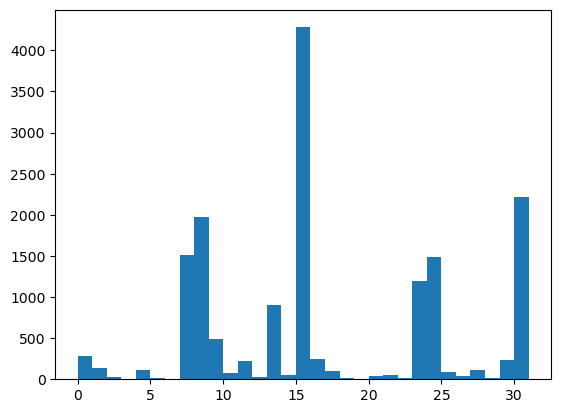

In [28]:
#frequency of optimal actions
plt.hist(stacked_actions[:,0,:], np.arange(32))

In [29]:
visit_count, idx_action = np.histogram(stacked_actions[:,3,:], np.arange(33))
(visit_count>100)*idx_action[:-1], visit_count # 0, 1, 7, 8, 9, 11, 13, 15, 16, 23, 24, 31

(array([ 0,  1,  0,  0,  4,  0,  0,  7,  8,  9,  0, 11,  0, 13, 14, 15, 16,
         0,  0,  0,  0,  0,  0, 23, 24,  0,  0, 27,  0, 29,  0, 31]),
 array([ 227,  175,   31,    2,  124,    1,    7, 1646, 2237,  469,   91,
         340,   50,  831,  151, 4639,  313,   65,   25,    7,   32,   13,
          10, 1078, 1260,   79,   43,  104,   17,  137,   62, 1734],
       dtype=int64))

In [30]:
#extracts data from dataset and then checks it

i = idx
x0 = stacked_states2[idx,0,0]

cbuy_tmp = stacked_states2[idx,0,1:1+N]
csell_tmp = stacked_states2[idx,0,1+N:1+2*N]
cprod_tmp = stacked_states2[idx,0,1+2*N:1+3*N]
power_res_tmp = stacked_states2[idx,0,1+3*N:1+4*N]
power_load_tmp = stacked_states2[idx,0,1+4*N:i+5*N]

mdl = hybrid_fhocp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp)

#show all variables and their respective values and index
i=0
for v in mdl.getVars():
    print('%s %g %i' % (v.VarName, v.X, i))
    i+=1

x[0,0] 231.007 0
x[1,0] 231.007 1
x[2,0] 231.007 2
x[3,0] 231.007 3
x[4,0] 231.007 4
x[5,0] 231.007 5
x[6,0] 231.007 6
x[7,0] 231.007 7
x[8,0] 231.007 8
x[9,0] 231.007 9
x[10,0] 231.007 10
x[11,0] 231.007 11
x[12,0] 231.007 12
x[13,0] 231.007 13
x[14,0] 180.502 14
x[15,0] 176.515 15
x[16,0] 176.515 16
x[17,0] 176.515 17
x[18,0] 176.515 18
x[19,0] 126.01 19
x[20,0] 75.5051 20
x[21,0] 25 21
x[22,0] 25 22
x[23,0] 25 23
x[24,0] 25 24
z[0,0] 0 25
z[0,1] 509.788 26
z[1,0] 0 27
z[1,1] 531.547 28
z[2,0] 0 29
z[2,1] 534.721 30
z[3,0] 0 31
z[3,1] 529.557 32
z[4,0] 0 33
z[4,1] 515.664 34
z[5,0] 0 35
z[5,1] 501.071 36
z[6,0] 0 37
z[6,1] 476.288 38
z[7,0] 0 39
z[7,1] 458.435 40
z[8,0] 0 41
z[8,1] 444.812 42
z[9,0] 0 43
z[9,1] 471.582 44
z[10,0] 0 45
z[10,1] 449.821 46
z[11,0] 0 47
z[11,1] 433.457 48
z[12,0] 0 49
z[12,1] 413.048 50
z[13,0] 0 51
z[13,1] 303.89 52
z[14,0] 0 53
z[14,1] 390.588 54
z[15,0] 0 55
z[15,1] 391.149 56
z[16,0] 0 57
z[16,1] 382.289 58
z[17,0] 0 59
z[17,1] 376.304 60
z[18,0] 0 6

In [31]:
# training

input_size= 6
hidden_size=128
num_layers = 1
lr = 1e-4
n_actions = 32

network = Network(input_size, hidden_size, num_layers, lr, n_actions, batch_first=True)

batch_size = 32
# N_iter = 2*50000
N_iter = 500000

loss_vec = np.zeros((N_iter,1))

for i in range(N_iter):

    batch = np.random.choice(N_datapoints, batch_size, replace=False)

    state_batch = torch.tensor(stacked_states1_norm[batch], dtype=torch.float32)
    labels_batch = torch.tensor(stacked_labels[batch], dtype=torch.float32)

    h0 = torch.zeros(num_layers, batch_size, hidden_size)
    c0 = torch.zeros(num_layers, batch_size, hidden_size)

    net_eval = network(state_batch, h0, c0)

    loss = network.loss(net_eval, labels_batch)
    
    loss_vec[i] = loss.detach().numpy()

    network.zero_grad()        
    loss.backward()
    network.optimizer.step()

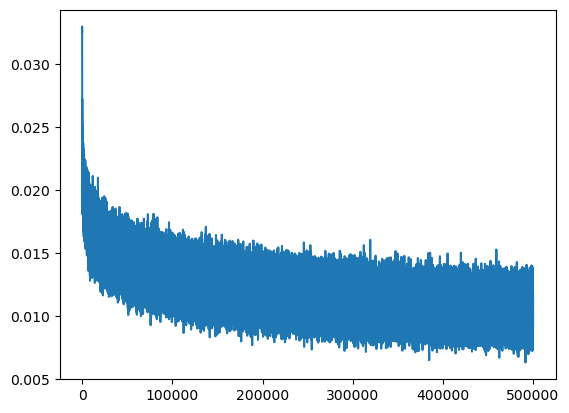

In [32]:
plt.plot(loss_vec)
plt.show()

In [33]:
#loss on training set

batch_size = 5000

batch = np.random.choice(N_datapoints, batch_size, replace=False)

state_batch = torch.tensor(stacked_states1_norm[batch], dtype=torch.float32)
labels_batch = torch.tensor(stacked_labels[batch], dtype=torch.float32)

h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)

net_eval = network(state_batch, h0, c0)

loss = network.loss(net_eval, labels_batch)

loss

tensor(0.0102, grad_fn=<MseLossBackward0>)

In [34]:
def get_optimality_gap(N, N_iter,
                    cbuy=cbuy, csell=csell, cprod=cprod, power_load=power_load, power_res=power_res):
    #computes the optimality gap (agent vs MILP) for the microgrid system
    #input: trained agent, environment, number of random iterations
    #output: averaged cost for agent, average optimal cost, and optimality gap

    cost_lstm_mem = []
    cost_optimal_mem = []
    
    diff_soc = []
   
    cntr_infeasible = 0    

    for k in range(N_iter):
               
        # cbuy_tmp = stacked_states2[idx,0,1:1+N]
        # csell_tmp = stacked_states2[idx,0,1+N:1+2*N]
        # cprod_tmp = stacked_states2[idx,0,1+2*N:1+3*N]
        # power_res_tmp = stacked_states2[idx,0,1+3*N:1+4*N]
        # power_load_tmp = stacked_states2[idx,0,1+4*N:i+5*N]
        
        j = np.random.randint(N_datapoints)
        
        i = int(stacked_indices[j])
        x0 = stacked_states1[j,0,0].reshape(1,)
        cbuy_tmp = cbuy[i:i+N]
        csell_tmp = csell[i:i+N]
        cprod_tmp = cprod[i:i+N]
        power_res_tmp = power_res[i:i+N]
        power_load_tmp = power_load[i:i+N]

        mdl_milp = hybrid_fhocp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp)
        
        state = torch.tensor(stacked_states1_norm[j], dtype=torch.float32).unsqueeze(0)
        h0 = torch.zeros(num_layers, 1, hidden_size)
        c0 = torch.zeros(num_layers, 1, hidden_size)
        output_net = network(state, h0, c0)
                
        action_idx = torch.max(output_net, dim=2)[1].squeeze().numpy()
        delta = build_delta_vector(action_idx, N)
        
        mdl_lp = gurobi_qp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp, delta)        
        
        #this exludes infeasible actions from the computation
        if qp_feasible(mdl_lp):
            cost_mdl_lp = mdl_lp.ObjVal - np.max(csell_tmp)*(mdl_lp.getVars()[N].x - mdl_milp.getVars()[N].x)
            
            cost_optimal_mem.append(mdl_milp.ObjVal)
            cost_lstm_mem.append(cost_mdl_lp)
            diff_soc.append(mdl_lp.getVars()[N].x - mdl_milp.getVars()[N].x)
        else:
            cntr_infeasible += 1          
          
    avg_cost_lstm = sum(cost_lstm_mem)/len(cost_lstm_mem)
    avg_cost_optimal = sum(cost_optimal_mem)/len(cost_optimal_mem)
    optimality_gap = (avg_cost_lstm-avg_cost_optimal)/avg_cost_optimal
    
    return avg_cost_lstm, avg_cost_optimal, optimality_gap, cntr_infeasible

In [35]:
def get_optimality_gap_test(N, N_iter,
                    cbuy=cbuy, csell=csell, cprod=cprod, power_load=power_load, power_res=power_res):
    #computes the optimality gap (agent vs MILP) for the microgrid system
    #input: trained agent, environment, number of random iterations
    #output: averaged cost for agent, average optimal cost, and optimality gap

    cost_lstm_mem = []
    cost_optimal_mem = []
    
    diff_soc = []
   
    cntr_infeasible = 0    

    for k in range(N_iter):                
       
        x0 = np.random.rand(1,1)*225+25 #minimum battery level is 25        
        i = np.random.randint(cbuy.shape[0]-N)        
        cbuy_tmp = cbuy[i:i+N]
        csell_tmp = csell[i:i+N]
        cprod_tmp = cprod[i:i+N]
        power_res_tmp = power_res[i:i+N]
        power_load_tmp = power_load[i:i+N]
        state = build_stacked_input(x0, i, N, input_size, state_min, state_max,
                        cbuy, csell, cprod, power_load, power_res)

        mdl_milp = hybrid_fhocp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp)
        
        state = torch.tensor(state, dtype=torch.float32)#.unsqueeze(0)
        h0 = torch.zeros(num_layers, 1, hidden_size)
        c0 = torch.zeros(num_layers, 1, hidden_size)
        output_net = network(state, h0, c0)
                
        action_idx = torch.max(output_net, dim=2)[1].squeeze().numpy()
        delta = build_delta_vector(action_idx, N)
        
        mdl_lp = gurobi_qp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp, delta)        
        
        #this exludes infeasible actions from the computation
        if qp_feasible(mdl_lp):
            cost_mdl_lp = mdl_lp.ObjVal - np.max(csell_tmp)*(mdl_lp.getVars()[N].x - mdl_milp.getVars()[N].x)
            
            cost_optimal_mem.append(mdl_milp.ObjVal)
            cost_lstm_mem.append(cost_mdl_lp)
            diff_soc.append(mdl_lp.getVars()[N].x - mdl_milp.getVars()[N].x)
        else:
            cntr_infeasible += 1          
          
    avg_cost_lstm = sum(cost_lstm_mem)/len(cost_lstm_mem)
    avg_cost_optimal = sum(cost_optimal_mem)/len(cost_optimal_mem)
    optimality_gap = (avg_cost_lstm-avg_cost_optimal)/avg_cost_optimal
    
    return avg_cost_lstm, avg_cost_optimal, optimality_gap, cntr_infeasible

In [90]:
N=24
N_iter=200
network.eval()
avg_cost_lstm, avg_cost_optimal, optimality_gap, cntr_infeasible = get_optimality_gap(N, N_iter)
optimality_gap, cntr_infeasible, avg_cost_lstm, avg_cost_optimal

(0.0005968399216281363, 14, 3993.5828418611513, 3991.2007339279116)

In [38]:
N=48
N_iter=2000
network.eval()
avg_cost_lstm, avg_cost_optimal, optimality_gap, cntr_infeasible = get_optimality_gap_test(N, N_iter,
                                        cbuy=cbuy_2021, csell=csell_2021, cprod=cprod_2021, power_load=power_load_2021, power_res=power_res_2021)
optimality_gap, cntr_infeasible, avg_cost_lstm, avg_cost_optimal

(0.027971629004124986, 1929, 8120.351187654348, 7899.392316421374)

In [39]:
count_parameters(network)

73760

In [42]:
import time

list_SL = []

h0 = torch.zeros(num_layers, 1, hidden_size)
c0 = torch.zeros(num_layers, 1, hidden_size)
for i in range(1000):
    j = np.random.randint(stacked_states1_norm.shape[0])
    state = stacked_states1[j]
    
    start_time_RL = time.time()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    output_net = network(state, h0, c0)
    action_idx = torch.max(output_net, dim=2)[1].squeeze().numpy()
    delta = build_delta_vector(action_idx, N)

In [99]:
cbuy_2021.shape

(17520,)

In [89]:
state.shape

torch.Size([1, 24, 6])

In [75]:
state1.shape, state2.shape, type(state1[3]), type(state2[3])

((24, 6), (24, 6), numpy.ndarray, numpy.ndarray)

In [58]:
state = np.dstack((x0_tmp, cbuy_tmp, csell_tmp, cprod_tmp, power_res_tmp, power_load_tmp)).squeeze()
state.shape

(24, 6)

In [54]:
state = stacked_states1[j]
type(state), state.shape

(numpy.ndarray, (24, 6))

In [43]:
0.4/1000

0.0004

In [44]:
for i in range(100):
    x0 = np.random.rand(1,1)*225+25 #minimum battery level is 25        
    i = np.random.randint(cbuy.shape[0]-N)        
    cbuy_tmp = cbuy[i:i+N]
    csell_tmp = csell[i:i+N]
    cprod_tmp = cprod[i:i+N]
    power_res_tmp = power_res[i:i+N]
    power_load_tmp = power_load[i:i+N]

    mdl_milp = hybrid_fhocp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp)

In [45]:
28.2/100

0.282

In [46]:
(0.282-0.0004)/0.282*100

99.8581560283688

#### Save & Test

microgrid_lstm_supervised_128_opt1_N4:

    - lr=1e-4, hidden_size=128, training time=8+5=13m, datapoints: 100k, option1: forecasts spread over time
    
    - gap = 0.076%, infeasibility rate = 18/1000

microgrid_lstm_supervised_128_opt2_N4:

    - lr=1e-4, hidden_size=128, training time=8+5.5=13.5m, datapoints: 100k, option2: all inputs at the start
    
    - gap = 0.069%, infeasibility rate = 18/1000

microgrid_lstm_supervised_128_opt1_N12:

    - lr=1e-4, hidden_size=128, training time=21+23=44m, datapoints: 300k, option1: forecasts spread over time
    
    - gap = 0.11% / 0.12%, infeasibility rate = 36/1000 / 15/1000

microgrid_lstm_supervised_128_opt1_N48:

    - lr=1e-4, hidden_size=128, training time=82+150=232m, datapoints: 500k, option1: forecasts spread over time
    
    - gap = 0.06% / 0.18%, infeasibility rate = 111/1000 / 94/1000

In [15]:
#input_size=6 for option 1 and input_size=21 for option 2

input_size= 6
hidden_size=128
num_layers = 1
lr = 1e-4
n_actions = 32
batch_size = 1

network = Network(input_size, hidden_size, num_layers, lr, n_actions, batch_first=True)

In [91]:
# torch.save(network.state_dict(), 'best_weights//microgrid_lstm_supervised_%d_N%d_opt1'%(hidden_size, N))
# network.load_state_dict(torch.load('trained_weights//microgrid_lstm_supervised_128_option1'))

In [55]:
N=4
N_iter=2000
avg_cost_lstm, avg_cost_optimal, optimality_gap, cntr_infeasible = get_optimality_gap(N, N_iter)
optimality_gap, cntr_infeasible, avg_cost_lstm, avg_cost_optimal

(0.0007651083567837533, 89, 549.3427909794871, 548.9228055537287)

In [18]:
N=4
N_iter=2000
network.eval()
avg_cost_lstm, avg_cost_optimal, optimality_gap, cntr_infeasible = get_optimality_gap_test(N, N_iter,
                                        cbuy=cbuy_2021, csell=csell_2021, cprod=cprod_2021, power_load=power_load_2021, power_res=power_res_2021)
optimality_gap, cntr_infeasible, avg_cost_lstm, avg_cost_optimal

AssertionError: LSTM: Expected input to be 2-D or 3-D but received 4-D tensor

In [24]:
state.shape

torch.Size([1, 4, 6])

In [23]:
x0 = np.random.rand(1,1)*225+25 #minimum battery level is 25        
i = np.random.randint(cbuy.shape[0]-N)        
cbuy_tmp = cbuy[i:i+N]
csell_tmp = csell[i:i+N]
cprod_tmp = cprod[i:i+N]
power_res_tmp = power_res[i:i+N]
power_load_tmp = power_load[i:i+N]
state = build_stacked_input(x0, i, N, input_size, state_min, state_max,
                cbuy, csell, cprod, power_load, power_res)

mdl_milp = hybrid_fhocp(x0, N, power_res_tmp, power_load_tmp, cbuy_tmp, csell_tmp, cprod_tmp)

state = torch.tensor(state, dtype=torch.float32)#.unsqueeze(0)
h0 = torch.zeros(num_layers, 1, hidden_size)
c0 = torch.zeros(num_layers, 1, hidden_size)
output_net = network(state, h0, c0)